In [1]:
import csv
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import cv2
import imutils

In [2]:
def get_mask_info(prediction_path, annotation_file_path, mask_pred_path, mask_gt_path):
    images_names = [f for f in os.listdir(prediction_path)]
    pred_mask_list = []
    gt_mask_list = []
    coords_list = []
    coords_count_list = []
    data = pd.read_csv(annotation_file_path)
    img_name, count_coords = np.unique(data['image_name'], return_counts=True)
    for name in images_names:
        print(name)
        pred_mask_list.append(cv2.imread(mask_pred_path + name))
        gt_mask_list.append(cv2.imread(mask_gt_path + name))
        d = data[data['image_name'] == name[:-9]]
        x = np.array(d['x'])
        y = np.array(d['y'])
        coords = np.stack((y, x), axis=1)
        coords_list.append(coords)
        coords_count_list.append(count_coords[img_name == name[:-9]])
    
    return pred_mask_list, gt_mask_list, coords_list, coords_count_list

In [5]:
prediction_path = "dataset/single-channel-images/predictions/full_experiment_single_channel/"
annotation_file_path = "dataset/raw-data/annotations.csv"
mask_pred_path = os.path.join('dataset/single-channel-images/predictions/full_experiment_single_channel/')
mask_gt_path = os.path.join('dataset/single-channel-images/masks/')

pred_mask_list, gt_mask_list, coords_list, coords_count_list = \
        get_mask_info(prediction_path, annotation_file_path, mask_pred_path, mask_gt_path)

RPE1wt_CEP152+GTU88+PCNT_1_003_001_max_C1_mask.png
RPE1wt_CEP63+CETN2+PCNT_1_004_002_max_C3_mask.png
RPE1wt_CEP152+GTU88+PCNT_1_002_001_max_C1_mask.png
RPE1wt_CP110+GTU88+PCNT_2_003_003_max_C1_mask.png
RPE1wt_CEP152+GTU88+PCNT_1_001_001_max_C1_mask.png
RPE1wt_CEP63+CETN2+PCNT_1_002_001_max_C1_mask.png
RPE1wt_CEP152+GTU88+PCNT_1_004_002_max_C3_mask.png
RPE1wt_CEP63+CETN2+PCNT_1_004_004_max_C3_mask.png
RPE1wt_CEP152+GTU88+PCNT_1_000_003_max_C3_mask.png
RPE1wt_CEP63+CETN2+PCNT_1_000_004_max_C2_mask.png
RPE1wt_CP110+GTU88+PCNT_2_004_000_max_C1_mask.png
RPE1wt_CEP63+CETN2+PCNT_1_003_001_max_C2_mask.png
RPE1wt_CP110+GTU88+PCNT_2_003_004_max_C2_mask.png
RPE1wt_CP110+GTU88+PCNT_2_002_003_max_C2_mask.png
RPE1wt_CEP152+GTU88+PCNT_1_002_001_max_C2_mask.png
RPE1wt_CEP152+GTU88+PCNT_1_002_003_max_C1_mask.png
RPE1wt_CEP152+GTU88+PCNT_1_000_000_max_C2_mask.png
RPE1wt_CEP63+CETN2+PCNT_1_004_003_max_C1_mask.png
RPE1wt_CEP152+GTU88+PCNT_1_003_000_max_C3_mask.png
RPE1wt_CP110+GTU88+PCNT_2_002_001_max_C1_

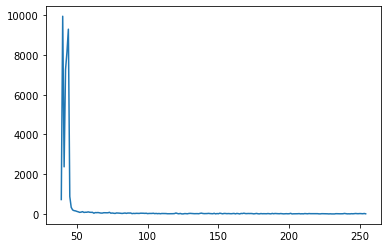

In [6]:
u, c = np.unique(pred_mask_list[0], return_counts=True)
start = 30
plt.plot(u[start:], c[start:])

## First
I tried to find the best threshold to minimize pixel-wise differences

In [6]:
mask_pred_path = os.path.join('datasets_full/single-channel-images/predictions/full_experiment/')
mask_gt_path = os.path.join('datasets_full/single-channel-images/masks/')
image_name = 'RPE1wt_CEP63+CETN2+PCNT_1_000_003_max_C3_mask.png'

In [7]:
mask_pred = cv2.imread(mask_pred_path + image_name) 
mask_gt = cv2.imread(mask_gt_path + image_name)

In [8]:
def best_threshold_pixel_wise(pred_masks, gt_masks):
    best_score = np.Inf
    best_trsh = 0
    scores_track = []
    for trsh in range(255):
        temp_score = 0
        for i, (pred, gt) in enumerate(zip(pred_masks, gt_masks)):
            print("threshold : {:3}, {:2}/{:2}, best_score : {:10}".format(trsh, i, len(pred_masks), best_score), end='\r')
            clean_mask = pred.copy()
            clean_mask[clean_mask >= trsh] = 255
            clean_mask[clean_mask <  trsh] = 0
            pixel_dist = np.abs(np.float32(clean_mask[:, :, 0]) - np.float32(gt[:, :, 0])) / 255
            temp_score += np.sum(pixel_dist)
            
        score = temp_score / len(pred_masks)
        scores_track.append(score)
        if score < best_score:
            best_trsh = trsh
            best_score = score
            
    return best_trsh, scores_track

In [9]:
best_thr, scores_track = best_threshold_pixel_wise(pred_mask_list, gt_mask_list)

KeyboardInterrupt: 

In [19]:
print(best_thr)

190


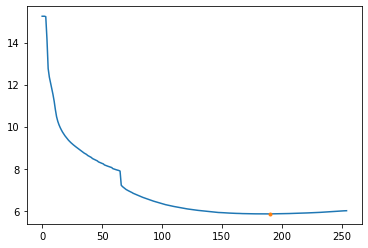

In [20]:
plt.plot(np.arange(255), np.log(scores_track))
plt.plot(best_thr, np.log(scores_track[best_thr]), ".")

In [23]:
clean_mask_list_pixel_wise = []
for img in pred_mask_list:
    img_c = img.copy()
    img_c[img_c >= best_thr] = 255
    img_c[img_c <  best_thr] = 0
    clean_mask_list_pixel_wise.append(img_c)

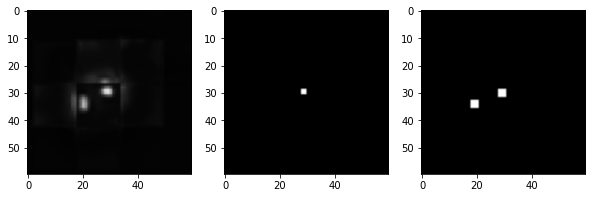

In [24]:
img_nb = 6
coords = np.argwhere(gt_mask_list[img_nb][:, :, 0] > 0)
fig, ax = plt.subplots(1, 3, figsize=(10,10))
window_size = 30
point_idx = 50
ax[0].imshow(pred_mask_list[img_nb][coords[point_idx, 0] - window_size : coords[point_idx, 0] + window_size, coords[point_idx, 1] - window_size : coords[point_idx, 1] + window_size])
ax[1].imshow(clean_mask_list_pixel_wise[img_nb][coords[point_idx, 0] - window_size : coords[point_idx, 0] + window_size, coords[point_idx, 1] - window_size : coords[point_idx, 1] + window_size])
ax[2].imshow(gt_mask_list[img_nb][coords[point_idx, 0] - window_size : coords[point_idx, 0] + window_size, coords[point_idx, 1] - window_size : coords[point_idx, 1] + window_size])

## Second
I tried to find the best threshold to maximize the number of detect center that diviate from 0 to 2 pixel from the ground truth center

In [11]:
def find_center_coordinates2(masks, trsh):
    image = masks.copy()
    image[image < trsh] = 0
    #image[image >= trsh] = 255
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    blurred = cv2.GaussianBlur(gray, (3, 3), 0)
    thresh = cv2.adaptiveThreshold(gray, 255, cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY, 3, -10)
    #blurred[blurred < trsh] = 0
    #blurred[blurred >= trsh] = 255
    cnts = cv2.findContours(blurred.copy(), cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)
    cnts = imutils.grab_contours(cnts)

    # loop over the contours
    centers_coords = []
    for c in cnts:
        M = cv2.moments(c)
        if M["m00"] != 0:
            cX = int(M["m01"] / M["m00"])
            cY = int(M["m10"] / M["m00"])
            centers_coords.append(np.array((cX, cY)))
        else:
            centers_coords.append(np.array((-1, -1)))
            
    return np.array(centers_coords), thresh

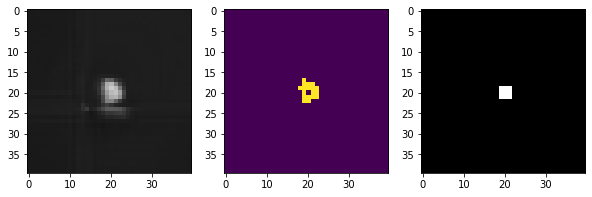

In [12]:
im_nb = 0
cc, thresh_img = find_center_coordinates2(pred_mask_list[im_nb], 98)
point = coords_list[im_nb][10]
window_size = 20
range_lx = np.maximum(point[0] - window_size, 0)
range_ux = np.minimum(point[0] + window_size, 2048)
range_ly = np.maximum(point[1] - window_size, 0)
range_uy = np.minimum(point[1] + window_size, 2048)
fig, ax = plt.subplots(1, 3, figsize=(10, 10))
ax[0].imshow(pred_mask_list[im_nb][range_lx:range_ux, range_ly:range_uy])
ax[1].imshow(thresh_img[range_lx:range_ux, range_ly:range_uy])
ax[2].imshow(gt_mask_list[im_nb][range_lx:range_ux, range_ly:range_uy])

In [13]:
def compute_threshold_mask(mask, trsh):
    image = mask.copy()
    image[image < trsh] = 0
    #image[image >= trsh] = 255
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    blurred = cv2.GaussianBlur(gray, (3, 3), 0)
    #blurred[blurred < trsh] = 0
    #blurred[blurred >= trsh] = 255
    thresh = cv2.adaptiveThreshold(blurred, 255, cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY, 3, -10)
    return thresh

In [14]:
def find_center_coordinates(thresh):
    cnts = cv2.findContours(thresh.copy(), cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)
    cnts = imutils.grab_contours(cnts)

    # loop over the contours
    centers_coords = []
    for c in cnts:
        M = cv2.moments(c)
        if M["m00"] != 0:
            cX = int(M["m01"] / M["m00"])
            cY = int(M["m10"] / M["m00"])
            centers_coords.append(np.array((cX, cY)))
        else:
            centers_coords.append(np.array((-1, -1)))
            
    return np.array(centers_coords)

In [15]:
def assign_pred_center_to_gt(pred_coords, gt_coords):
    assignment_list = []
    new_coords_centriol = np.array(pred_coords[pred_coords != [-1, -1]].reshape(-1, 2))
    temp_coords_centriol = new_coords_centriol.copy()
    for i, coord in enumerate(gt_coords):
        vx = coord[0] - temp_coords_centriol[:, 0]
        vy = coord[1] - temp_coords_centriol[:, 1]
        dist = np.linalg.norm(coord - temp_coords_centriol, axis=1)
        if dist.size != 0:
            min_dist = np.argmin(dist)
            if dist[min_dist] < 3:
                temp_coords_centriol[min_dist] = np.array((np.Inf, np.Inf))
                assignment_list.append((i, min_dist))
    return np.array(assignment_list)

In [31]:
def best_threshold_coord_nb(pred_masks, gt_masks, count_coords, gt_coords):
    best_trsh = 0
    scores_track = []
    scores_track.append(0)
    scnd_track = []
    scnd_track.append(0)
    best_score = 0
    total_count = 0
    j = 0
    for trsh in range(0, 255):
        temp_count = 0
        scnd_count = 0
        for i, (pred, gt) in enumerate(zip(pred_masks, gt_masks)):
            if scnd_track[j] != 0:
                print("threshold : {:3}, {:2}/{:2}, percentage detected centriol {:3.3}, precision {:5}"\
                      .format(trsh, i, len(pred_masks), 100 * scores_track[j] / np.sum(count_coords), 100 * scores_track[j] / scnd_track[j]), end='\r')

            thresh = compute_threshold_mask(pred, trsh)
            centers_coords = find_center_coordinates(thresh)
            new_centers_coords = centers_coords[centers_coords != np.array((-1, -1))].reshape(-1, 2)
            assign_center = assign_pred_center_to_gt(centers_coords, gt_coords[i])
            scnd_count += len(new_centers_coords)
            temp_count += len(assign_center)
        
        scores_track.append(temp_count)
        scnd_track.append(scnd_count)
        if temp_count > best_score:
            best_trsh = trsh
            best_score = temp_count
            total_count = temp_count
        j += 1
    return best_trsh, scores_track, scnd_track

In [32]:
best_trsh, scores_track, scnd_track = best_threshold_coord_nb(pred_mask_list, gt_mask_list, coords_count_list, coords_list)

/Users/AntoineDaeniker/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/Users/AntoineDaeniker/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  This is separate from the ipykernel package so we can avoid doing imports until


0.8503336510962822 0.8495238095238096


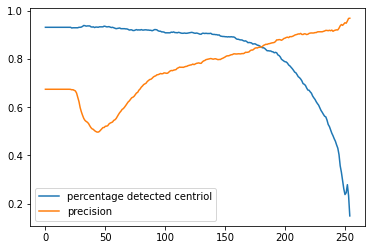

In [60]:
plt.plot(np.arange(len(scores_track) - 1) + 0, (scores_track[1:] / np.sum(coords_count_list)), label='percentage detected centriol')
plt.plot(np.arange(len(scores_track) - 1) + 0, (np.array(scores_track[1:]) / np.array(scnd_track[1:])), label='precision')
plt.legend()
crossing = np.argmin(np.abs((scores_track[1:] / np.sum(coords_count_list) - np.array(scores_track[1:]) / np.array(scnd_track[1:]))))
print((scores_track[1:] / np.sum(coords_count_list))[crossing], (np.array(scores_track[1:]) / np.array(scnd_track[1:]))[crossing])

In [61]:
best_trsh = crossing
print(best_trsh)

180


In [68]:
clean_mask_list = []
for img in pred_mask_list:
    thresh = compute_threshold_mask(img, best_trsh)
    clean_mask_list.append(thresh)
    
img_nb = 1
center_centriol = find_center_coordinates(clean_mask_list[img_nb])
for i, cm in enumerate(clean_mask_list):
    clean_mask_list[i] = np.repeat(cm[:, :, np.newaxis], 3, axis=2)

In [69]:
center_centriol_re = center_centriol[center_centriol != np.array((-1, -1))].reshape(-1, 2)
assign_center = assign_pred_center_to_gt(center_centriol, coords_list[img_nb])
detect_centri_full = center_centriol_re.copy() #[assign_center[:, 1]]
print("total center detected : ", len(detect_centri_full))
detect_centri = center_centriol_re.copy() #[assign_center[:, 1]]
print("assign center to gt_center : ", len(detect_centri[assign_center[:, 1]]))
print("gt_center : ", len(coords_list[img_nb]))
gt_centri = coords_list[img_nb].copy() #[assign_center[:, 0]]

total center detected :  38
assign center to gt_center :  30
gt_center :  36


/Users/AntoineDaeniker/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  
/Users/AntoineDaeniker/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
/Users/AntoineDaeniker/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  # This is added back by InteractiveShellApp.init_path()


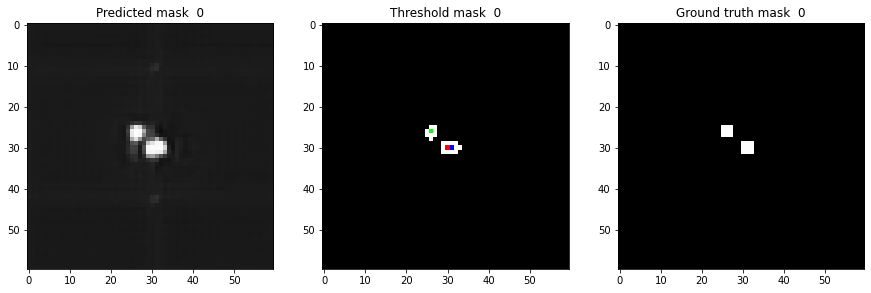

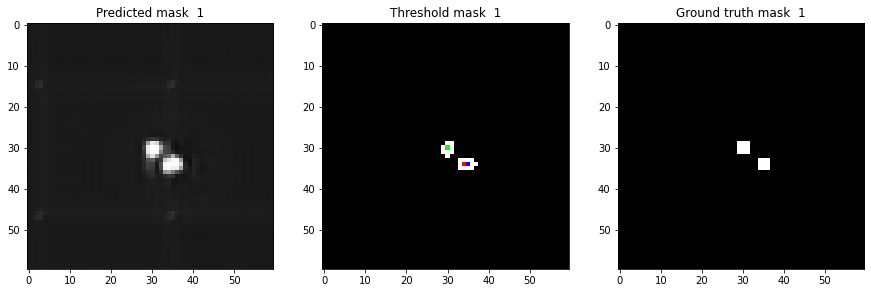

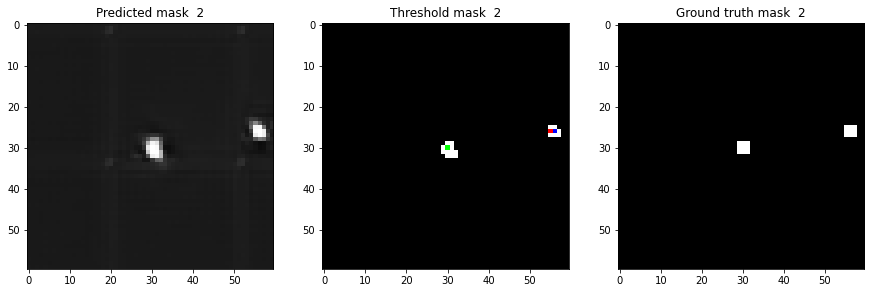

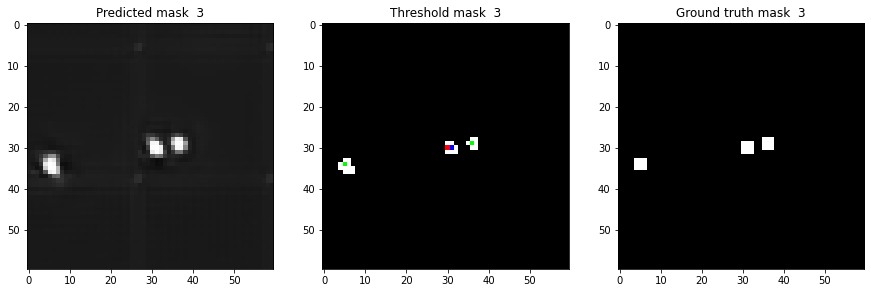

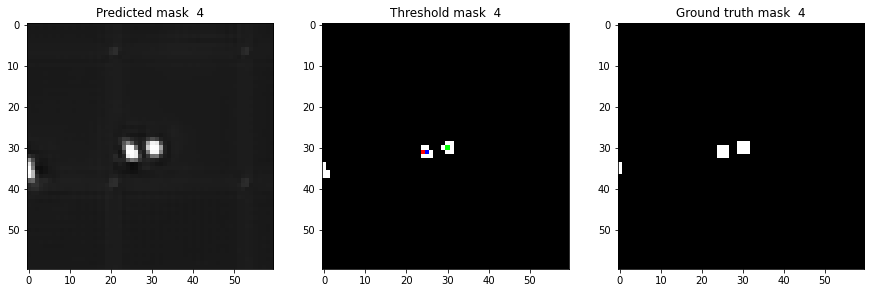

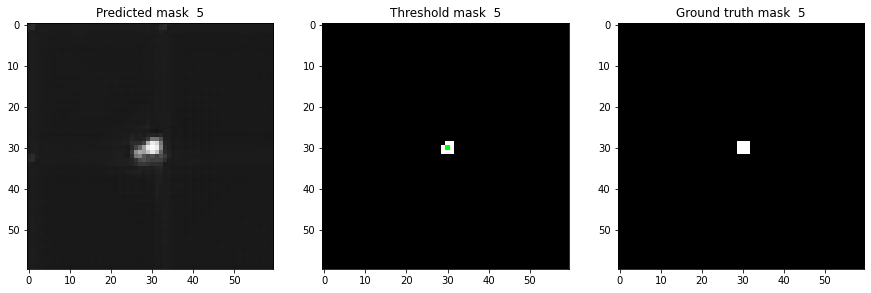

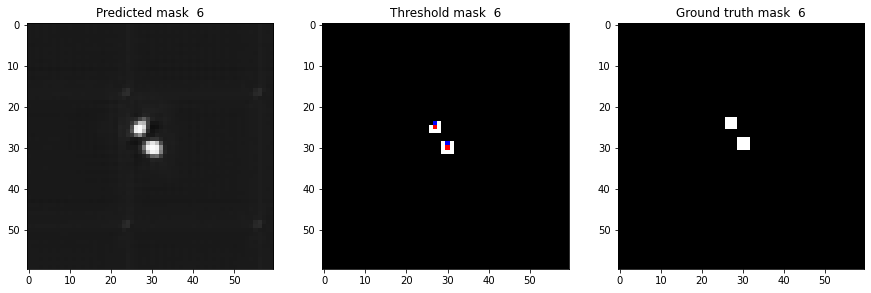

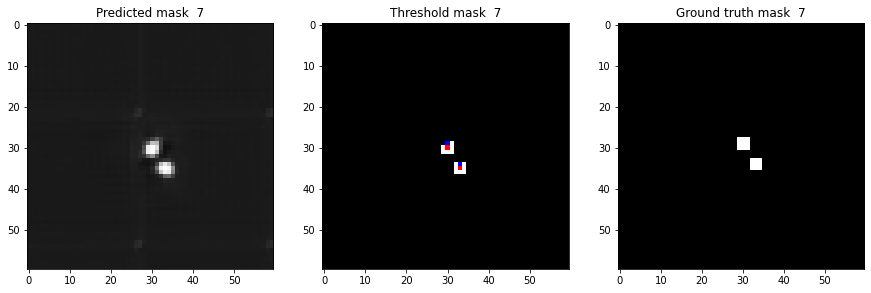

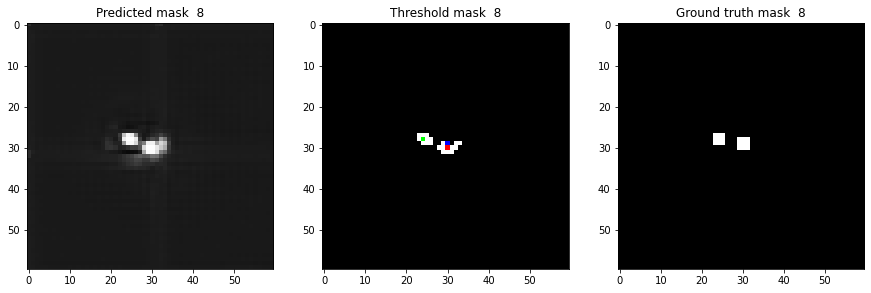

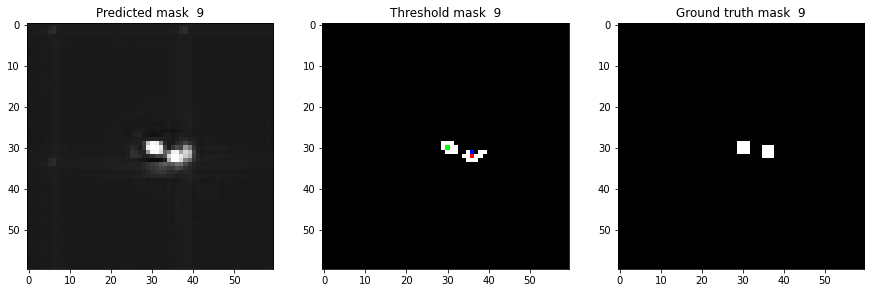

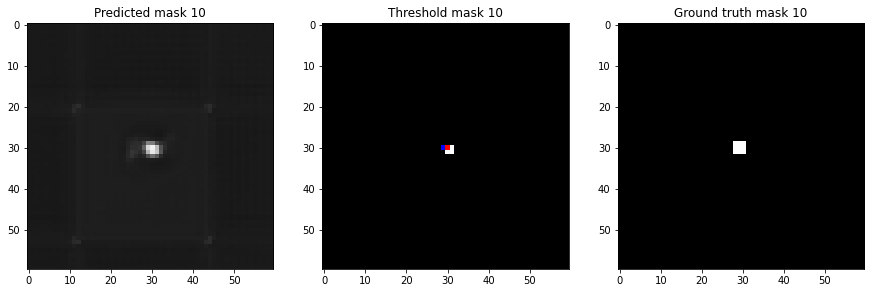

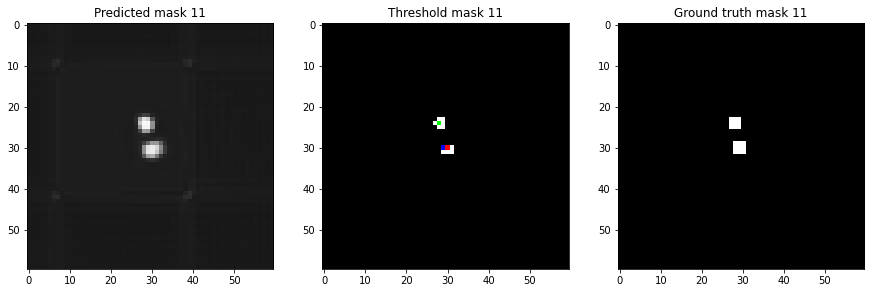

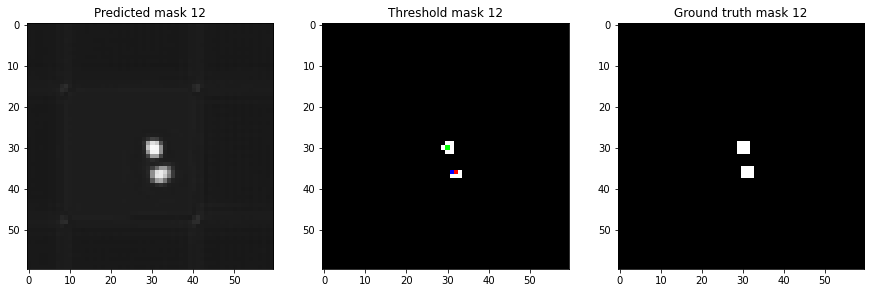

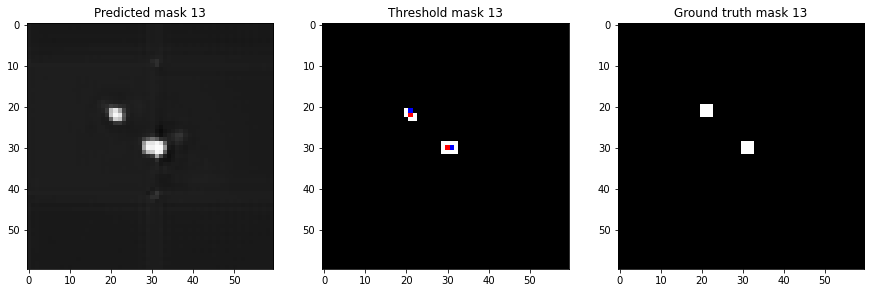

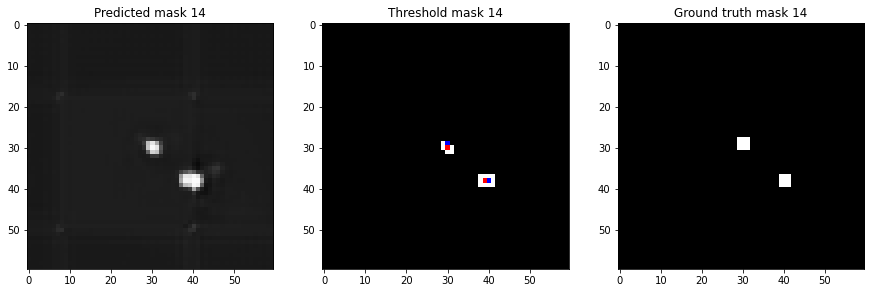

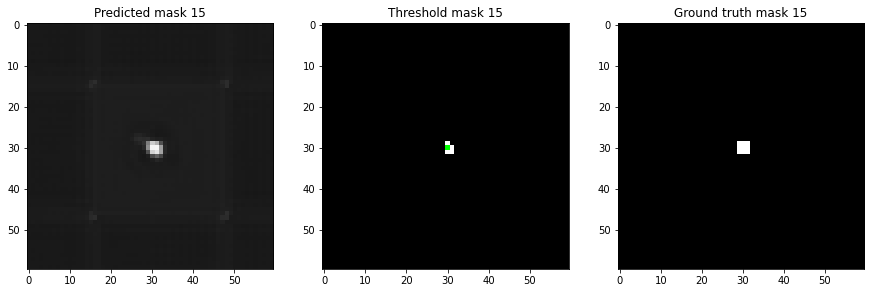

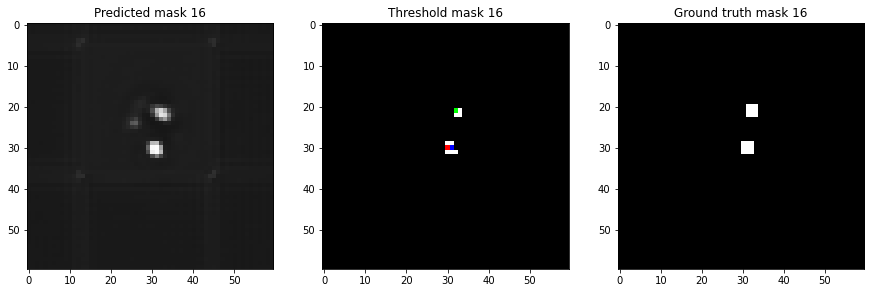

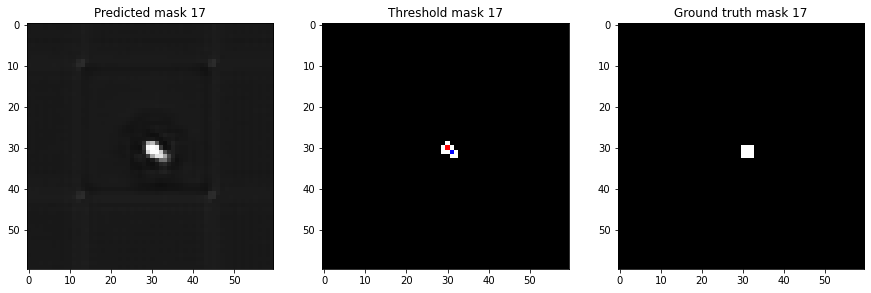

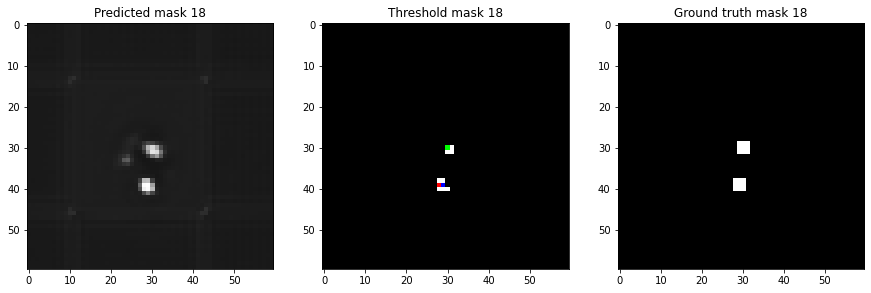

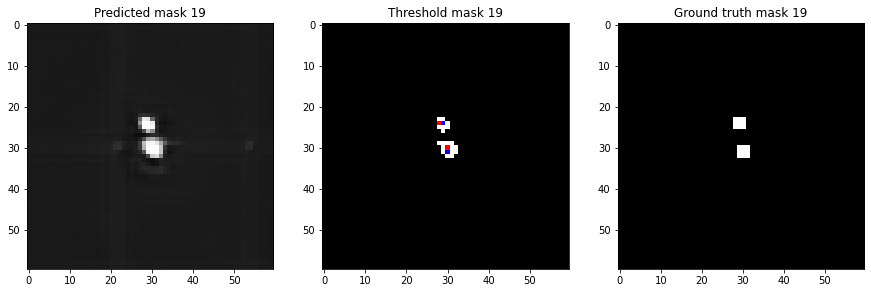

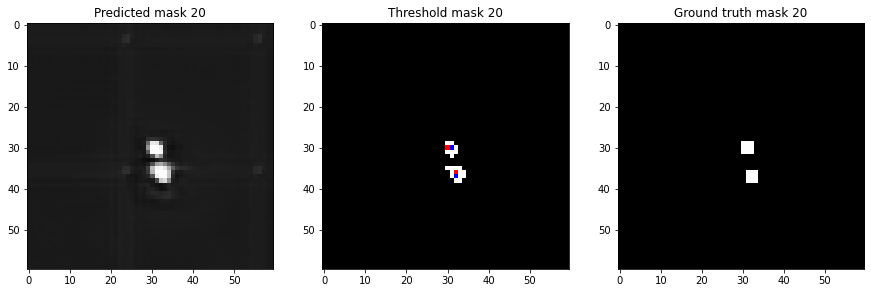

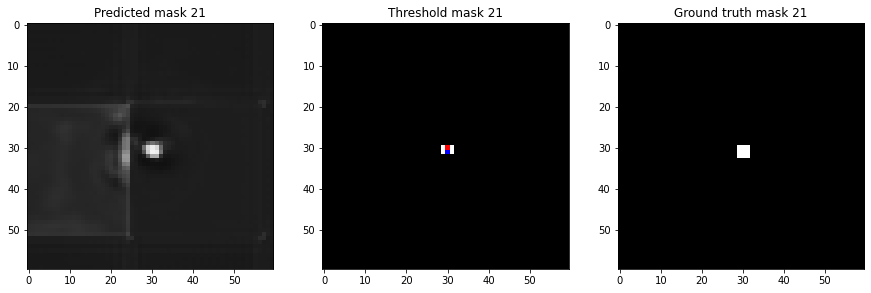

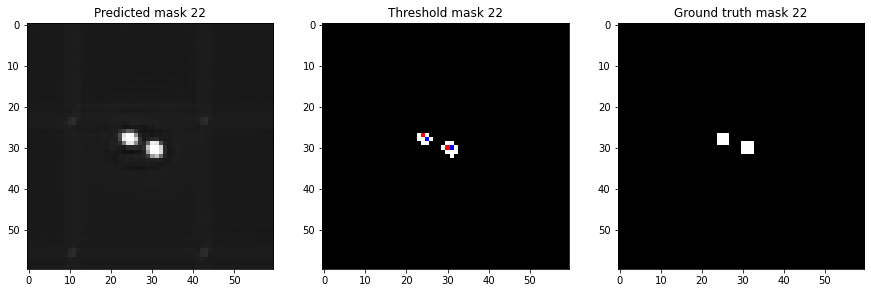

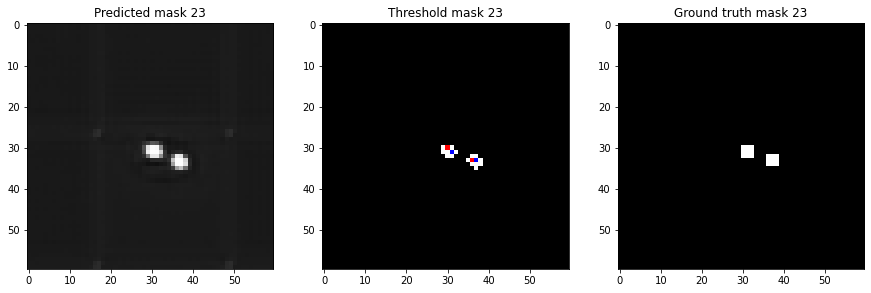

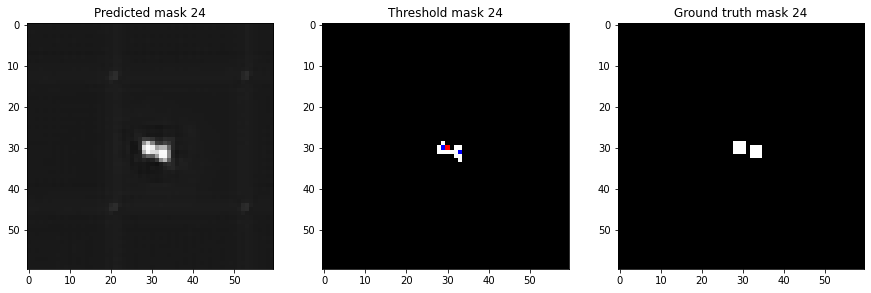

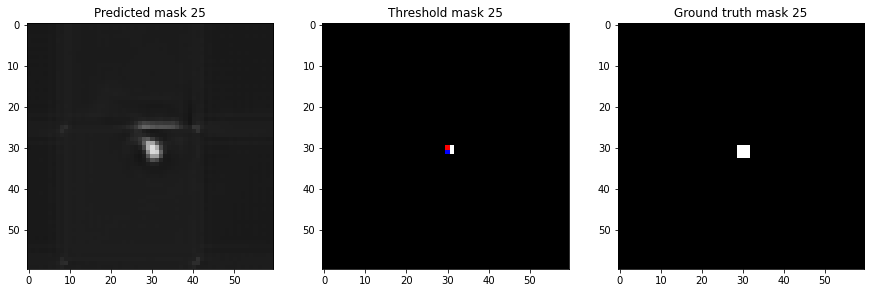

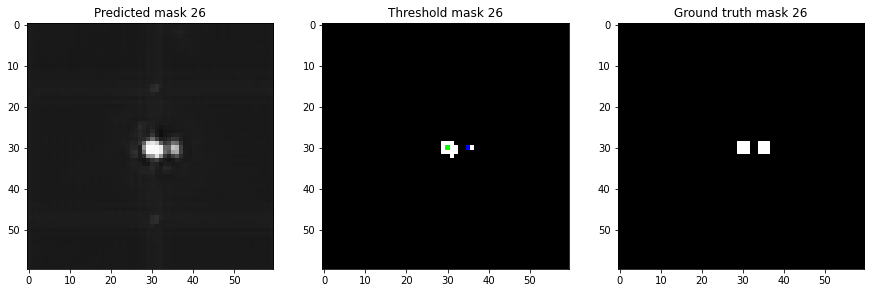

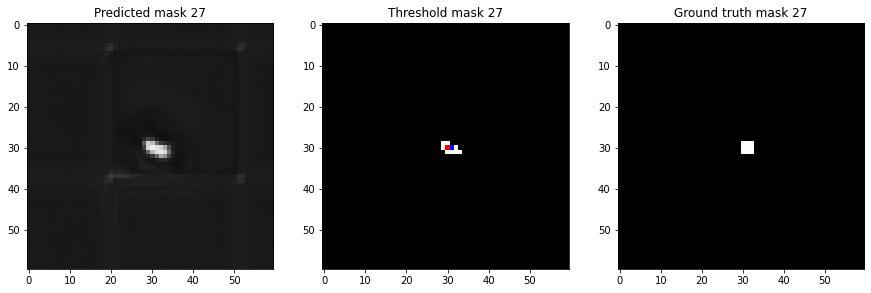

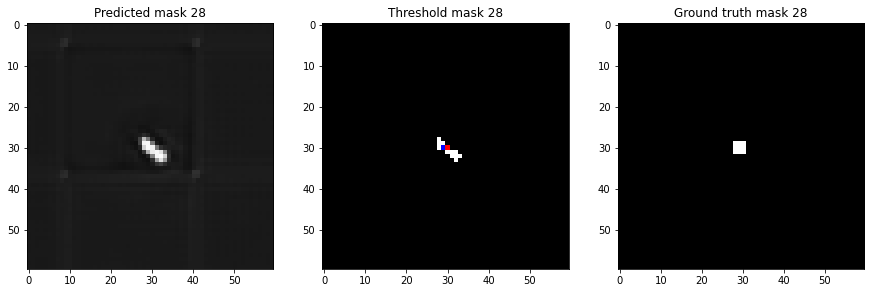

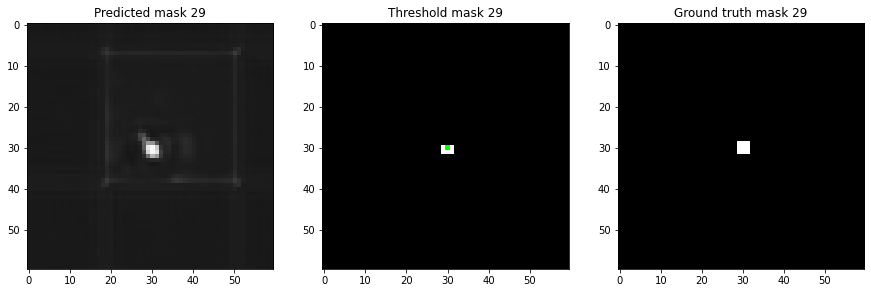

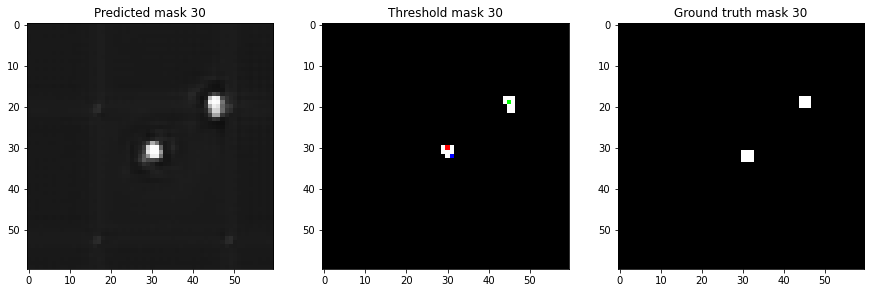

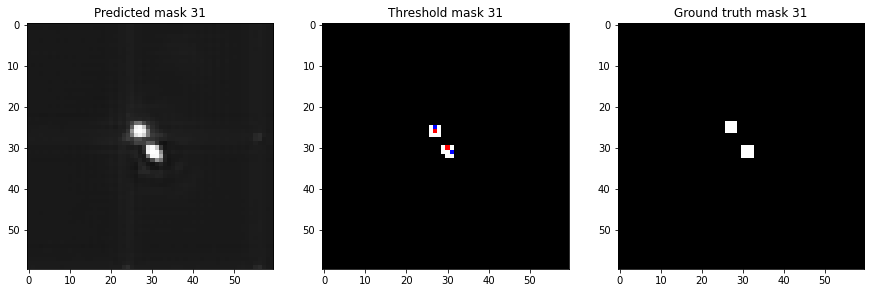

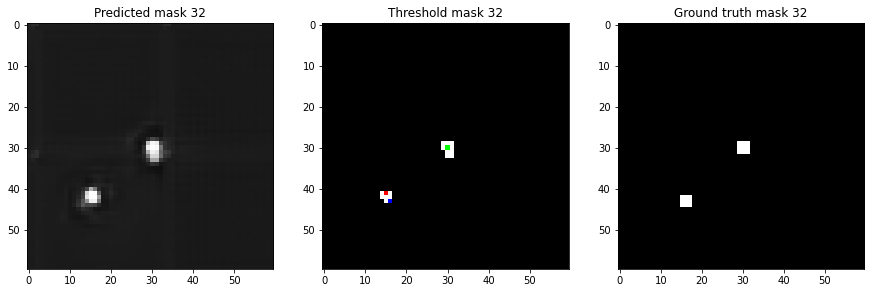

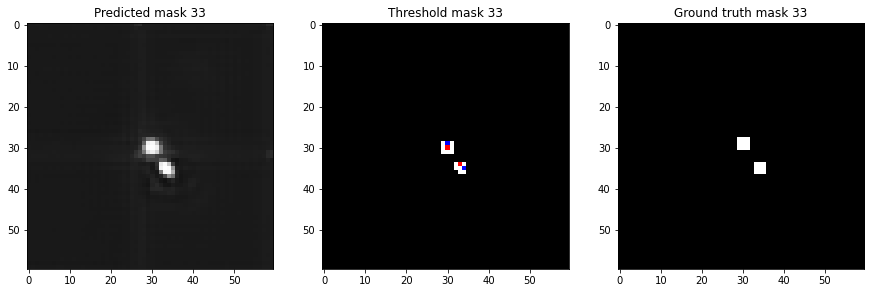

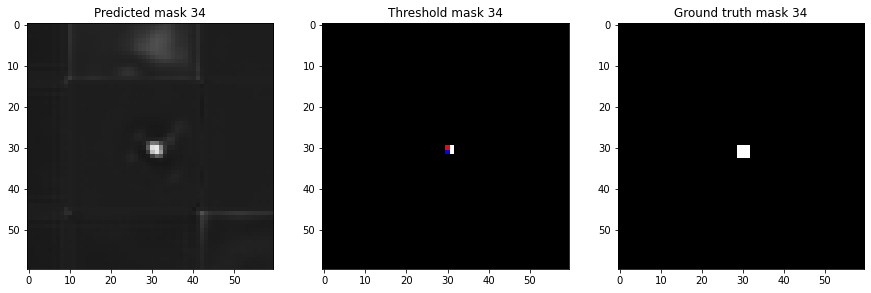

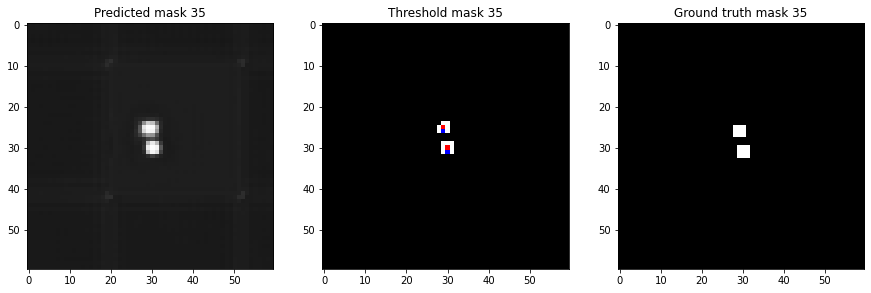

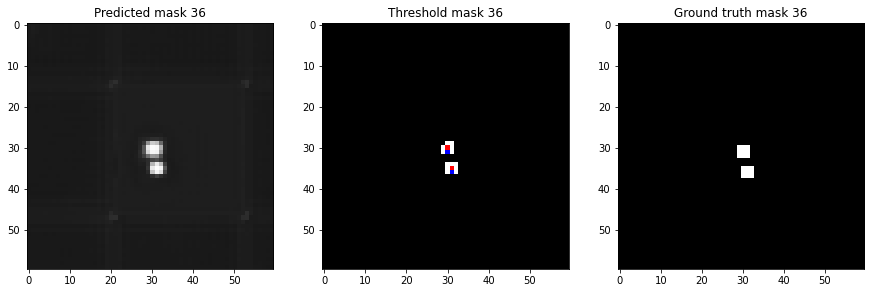

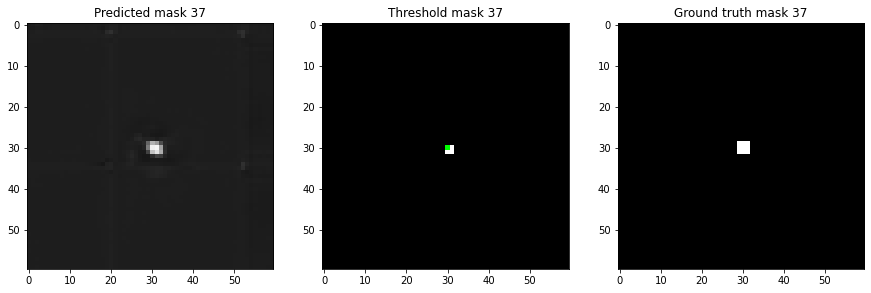

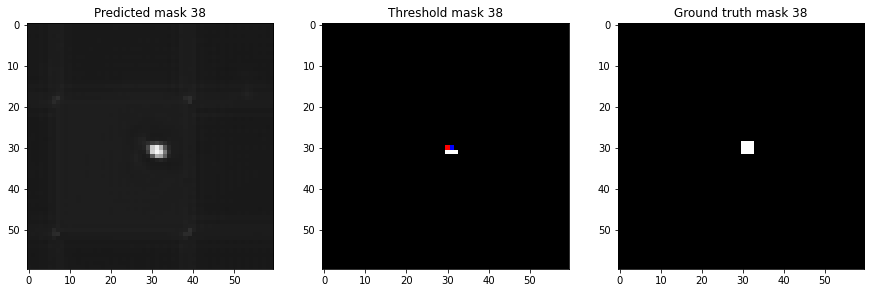

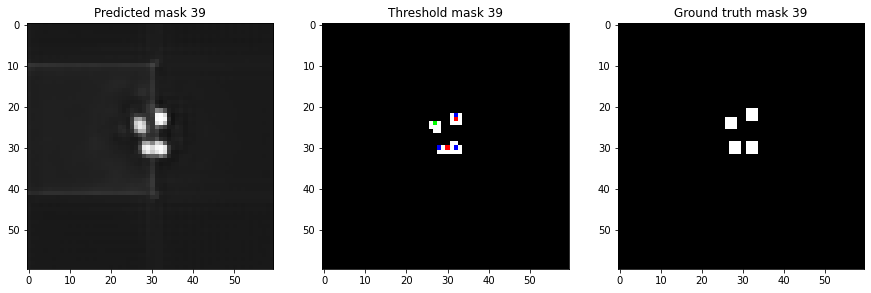

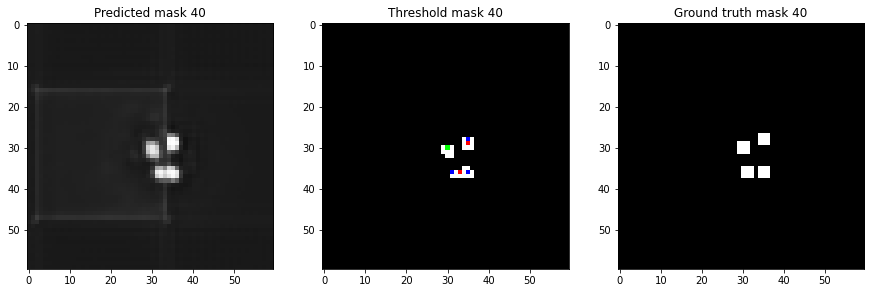

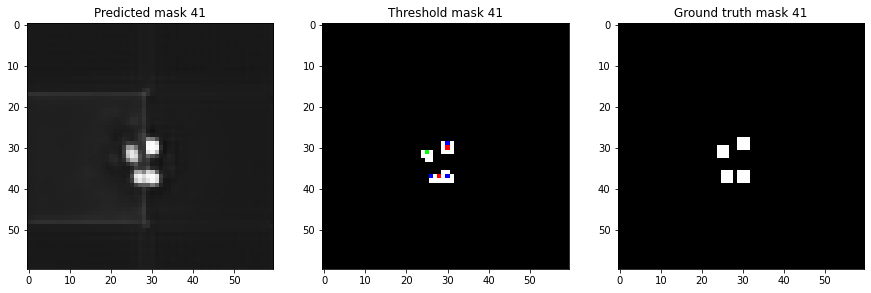

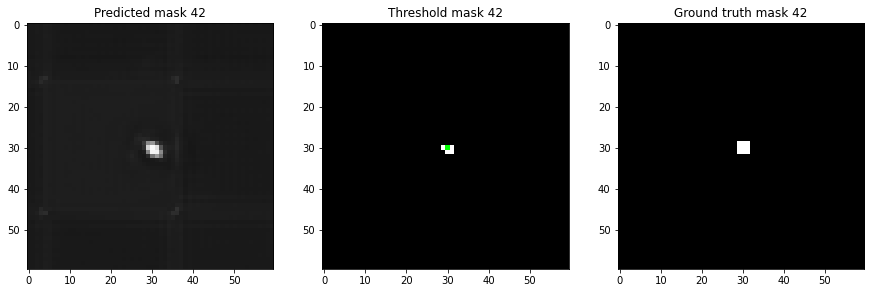

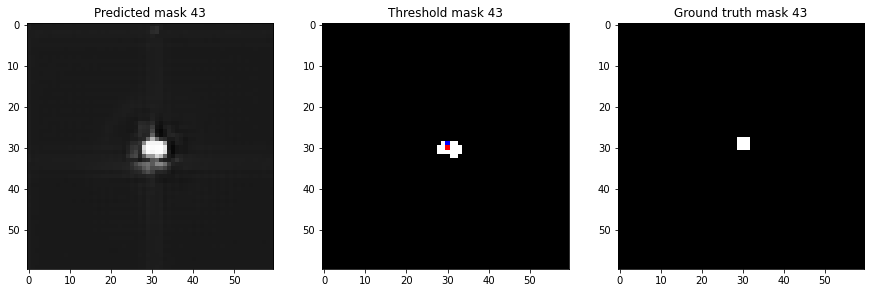

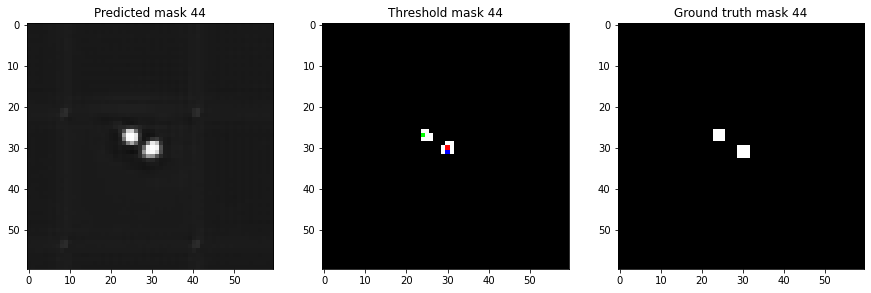

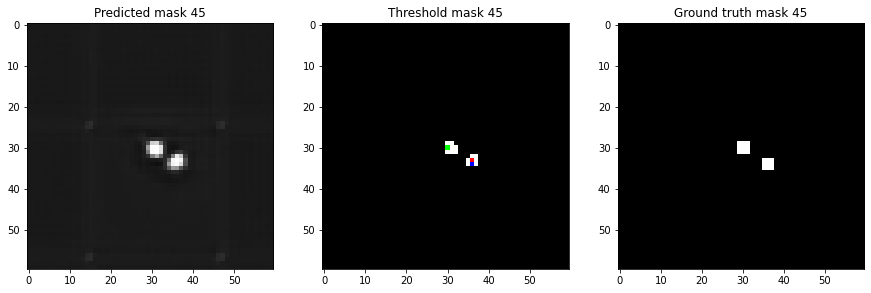

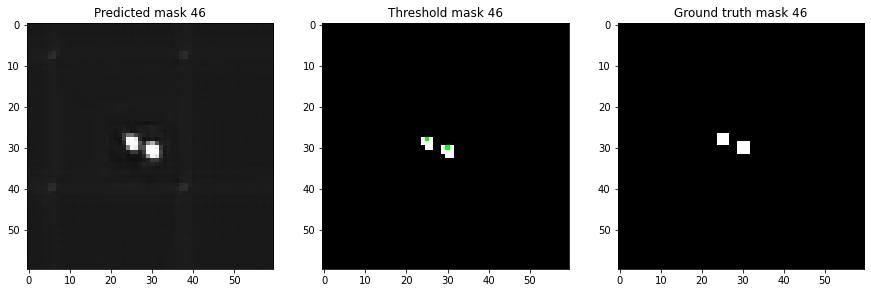

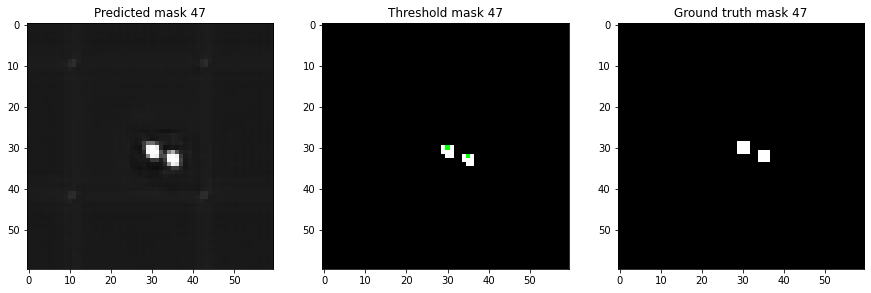

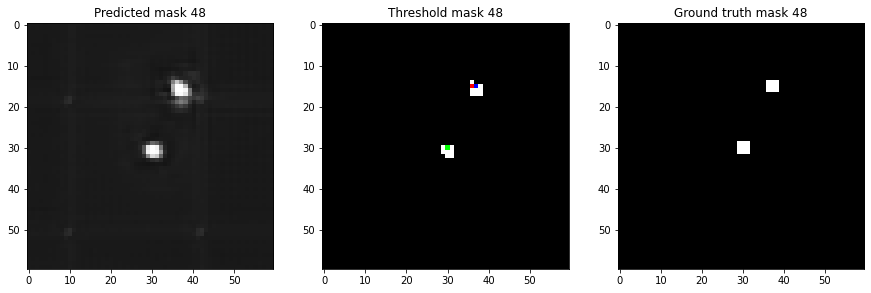

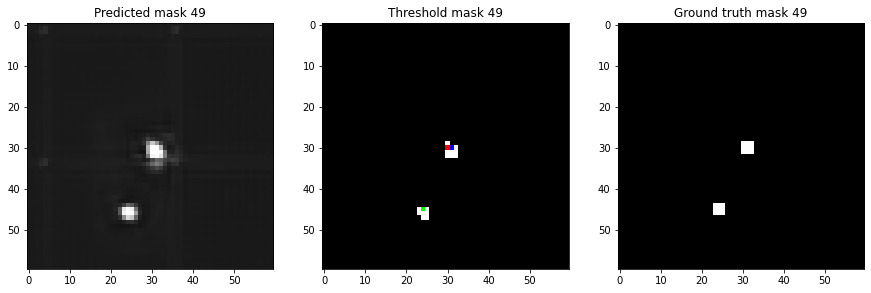

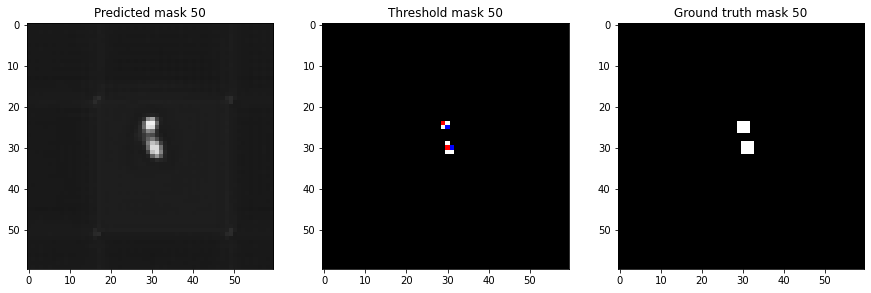

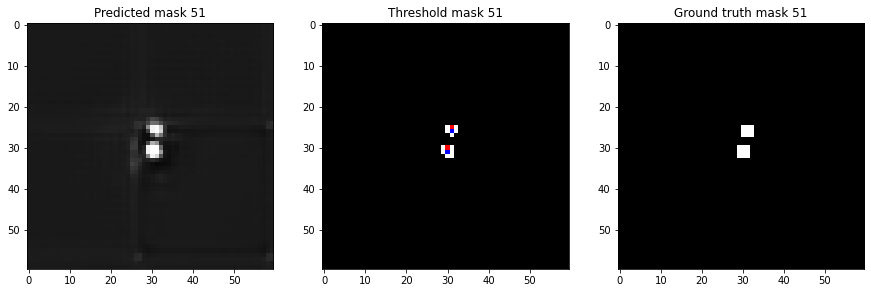

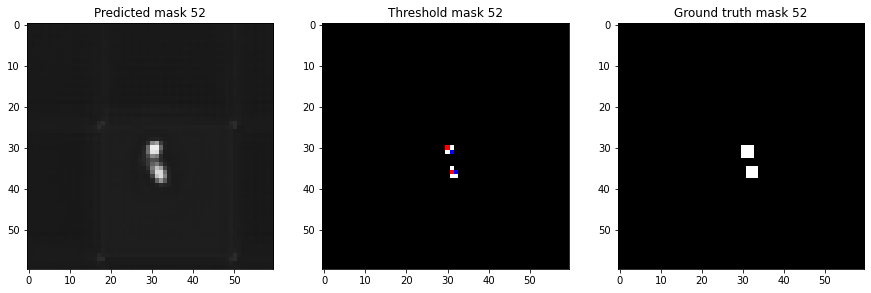

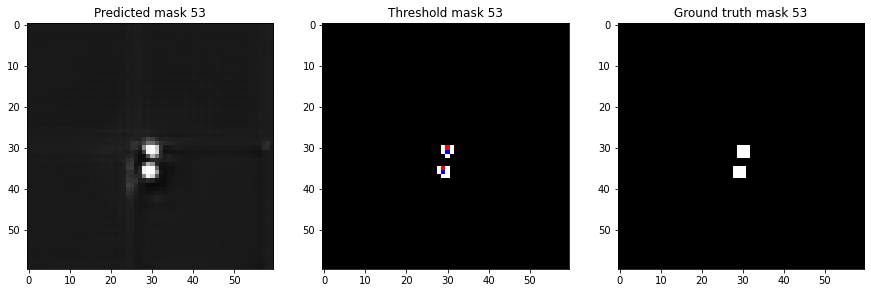

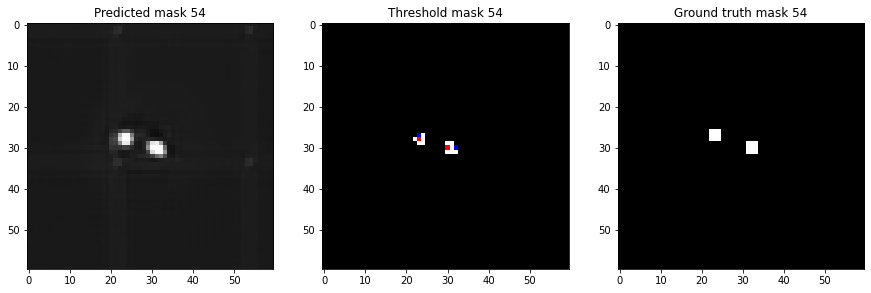

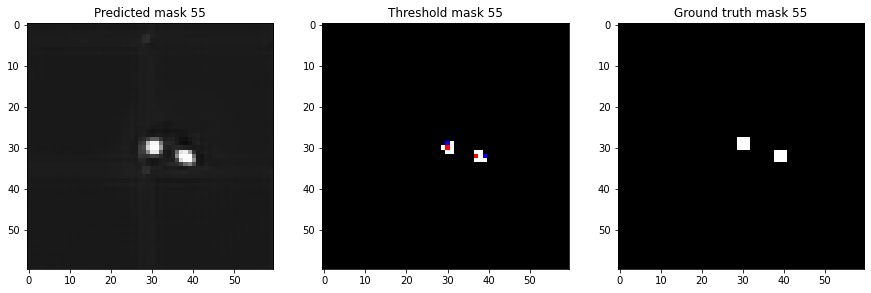

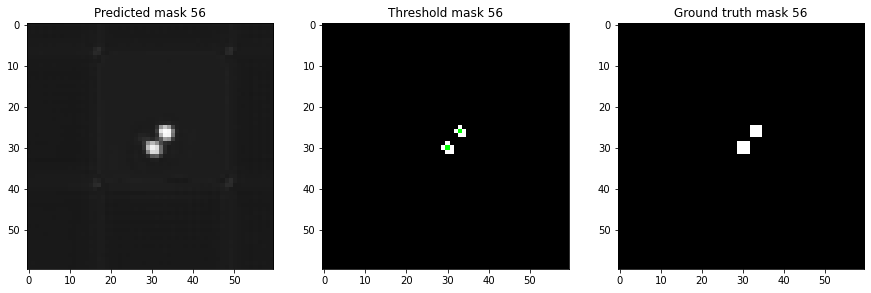

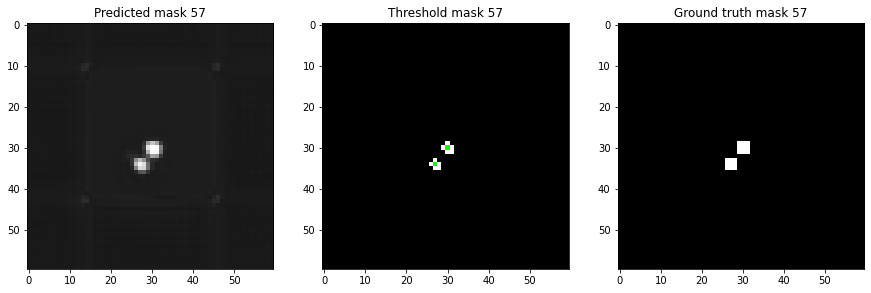

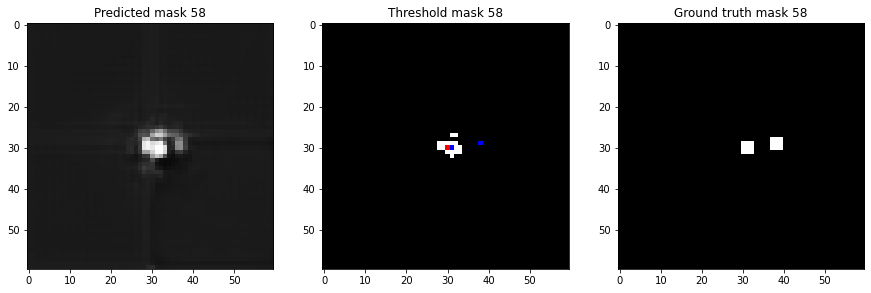

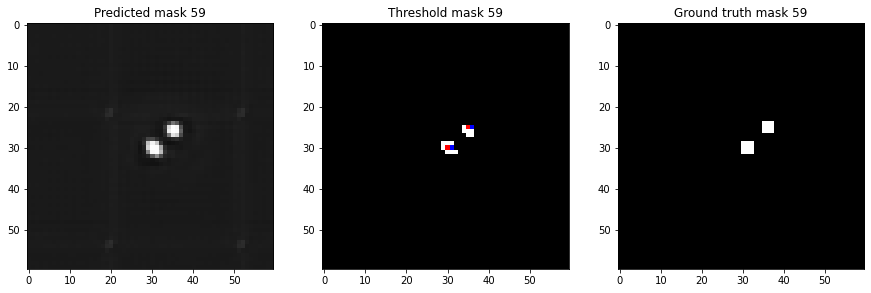

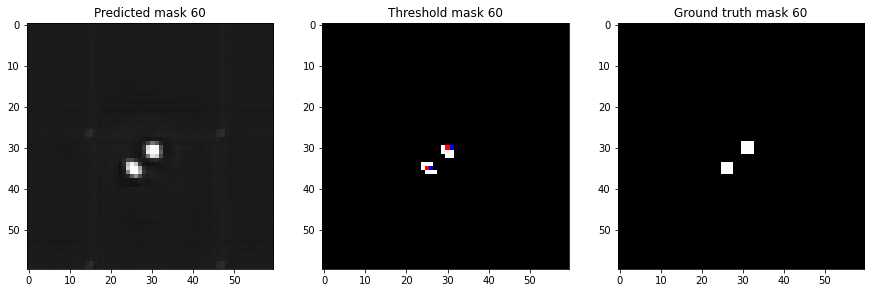

In [57]:
window_size = 30
new_clean_mask = clean_mask_list[img_nb].copy()
for gt_coord in gt_centri:
    new_clean_mask[gt_coord[0], gt_coord[1]] = np.array((0, 0, 255))
for i, coord in enumerate(detect_centri):
    if (np.any(np.argwhere(coord[0] == gt_centri[:, 0]) == np.argwhere(coord[1] == gt_centri[:, 1]))):
        new_clean_mask[coord[0], coord[1]] = np.array((0, 255, 0))
    else:
        new_clean_mask[coord[0], coord[1]] = np.array((255, 0, 0))
for point_idx in range(len(detect_centri)):
    fig, ax = plt.subplots(1, 3, figsize=(15,15))
    ax[0].imshow(pred_mask_list[img_nb][np.maximum(detect_centri[point_idx, 0] - window_size, 0) : detect_centri[point_idx, 0] + window_size, np.maximum(detect_centri[point_idx, 1] - window_size, 0) : detect_centri[point_idx, 1] + window_size])
    ax[1].imshow(new_clean_mask[np.maximum(detect_centri[point_idx, 0] - window_size, 0) : detect_centri[point_idx, 0] + window_size, np.maximum(detect_centri[point_idx, 1] - window_size, 0) : detect_centri[point_idx, 1] + window_size])
    ax[2].imshow(gt_mask_list[img_nb][np.maximum(detect_centri[point_idx, 0] - window_size, 0) : detect_centri[point_idx, 0] + window_size, np.maximum(detect_centri[point_idx, 1] - window_size, 0) : detect_centri[point_idx, 1] + window_size])
    ax[0].set_title("Predicted mask {:2}".format(point_idx))
    ax[1].set_title("Threshold mask {:2}".format(point_idx))
    ax[2].set_title("Ground truth mask {:2}".format(point_idx))
    fig.show()